**Sale focusting**
The Purpose of this notebook is  for educational both for the authore and whoever will come accrose the notebook

In [ ]:
#import necessary library
import os

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
sale_forecast = pd.read_csv("train.csv")
sale_forecast.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Let's for the null value in this dataset

In [ ]:
sale_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
#drop the column that won't be use in this column

sale_forecast = sale_forecast.drop(['store','item'], axis=1)
sale_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


The store and the item columN was deleted succesfully, now we are going to convert the date object datatype to datetime datatype


In [ ]:
sale_forecast['date'] = pd.to_datetime(sale_forecast['date'])
sale_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


Convert data to month period, and the the sum of the number of items in each month

In [ ]:
sale_forecast['date'] = sale_forecast['date'].dt.to_period("M")
monthly_sales = sale_forecast.groupby('date').sum().reset_index()
monthly_sales.head(5)

,date,sales
0,2013-01,454904
1,2013-02,459417
2,2013-03,617382
3,2013-04,682274
4,2013-05,763242


convert the result to date column to timestampdatatype

In [ ]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [ ]:
monthly_sales.head(15)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Visualization

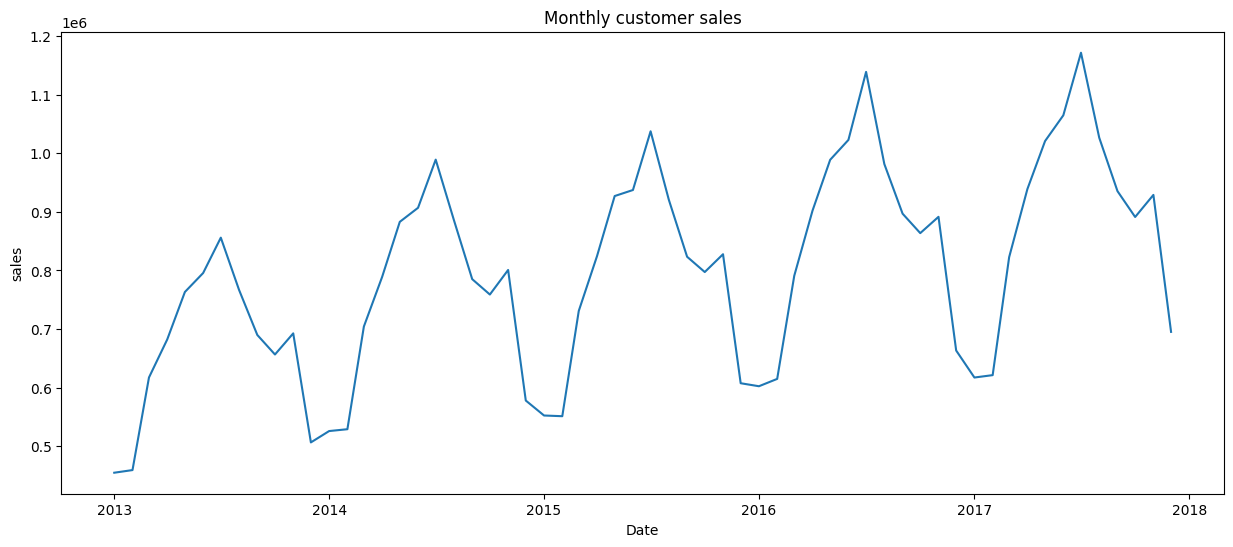

In [ ]:
plt.figure(figsize= (15,6))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Monthly customer sales")
plt.show()

Different on the sales column to make the sales data stationary

In [ ]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


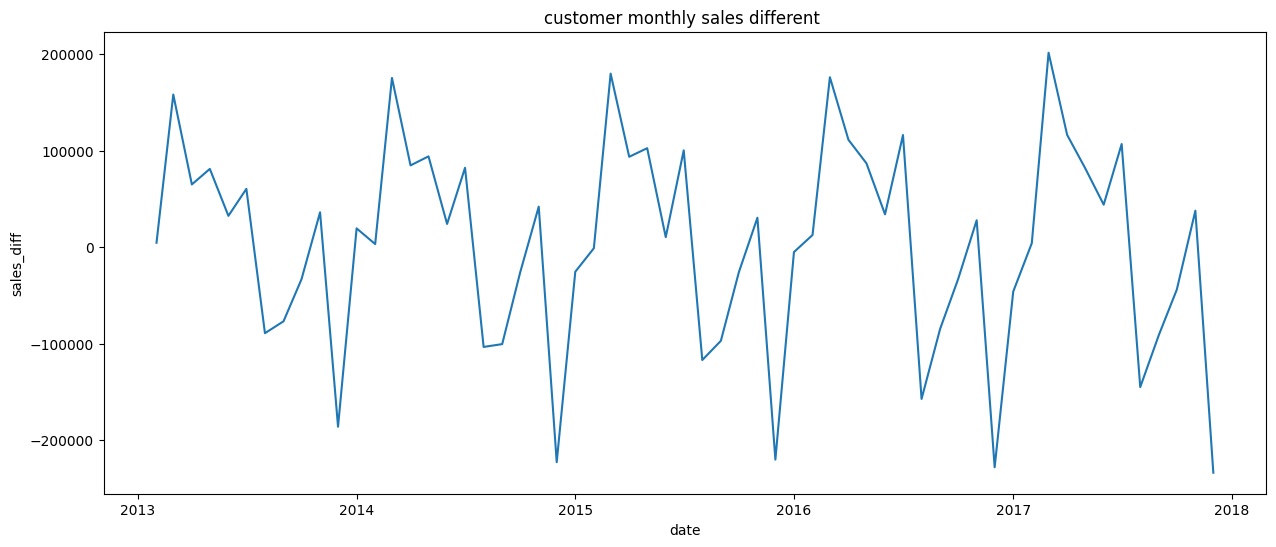

In [ ]:
#viz
plt.figure(figsize=(15,6))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('date')
plt.ylabel('sales_diff')
plt.title("customer monthly sales different ")
plt.show()

Dropping off the sales and date column for ML model


In [ ]:
sup_data = monthly_sales.drop(['date', 'sales'], axis=1)
sup_data

,sales_diff
1,4513.0
2,157965.0
3,64892.0
4,80968.0
5,32355.0
6,60325.0
7,-89161.0
8,-76854.0
9,-33320.0
10,36056.0


preparing the supervised learning data

In [ ]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  sup_data[col_name] = sup_data['sales_diff'].shift(i)
sup_data = sup_data.dropna().reset_index(drop=True)
sup_data.head(10)



,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


split the data into train nd test

In [ ]:
train_data = sup_data[:-12]
test_data = sup_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
test Data Shape:  (12, 13)


In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()

print("X_train Shape: ", x_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", x_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (35, 12)
y_train Shape:  (35,)
X_test Shape:  (12, 12)
y_test Shape:  (12,)


Prediction on the dataframe

In [ ]:
sale_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sale_dates)

In [ ]:
act_sale = monthly_sales['sales'][-13:].to_list()
print(act_sale)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


Creat the linear regression models, and the predict ouput

In [ ]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [ ]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix - contains the input feature of the test data, and also the predicted output
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)


In [ ]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+ act_sale[index])
lr_pre_series = pd.Series(result_list, name ="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index= True)

In [ ]:
print(predict_df)

         date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


In [ ]:
lr_mse = np.sqrt(mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linear Regression MSE:", lr_mse)
print("Linear Regression MAE:", lr_mae)
print("Linear Regression R2:", lr_r2)

Linear Regression MSE: 111.50418945712639
Linear Regression MAE: 12433.184266490736
Linear Regression R2: 0.9906152516380969


Visualisation of the prediction

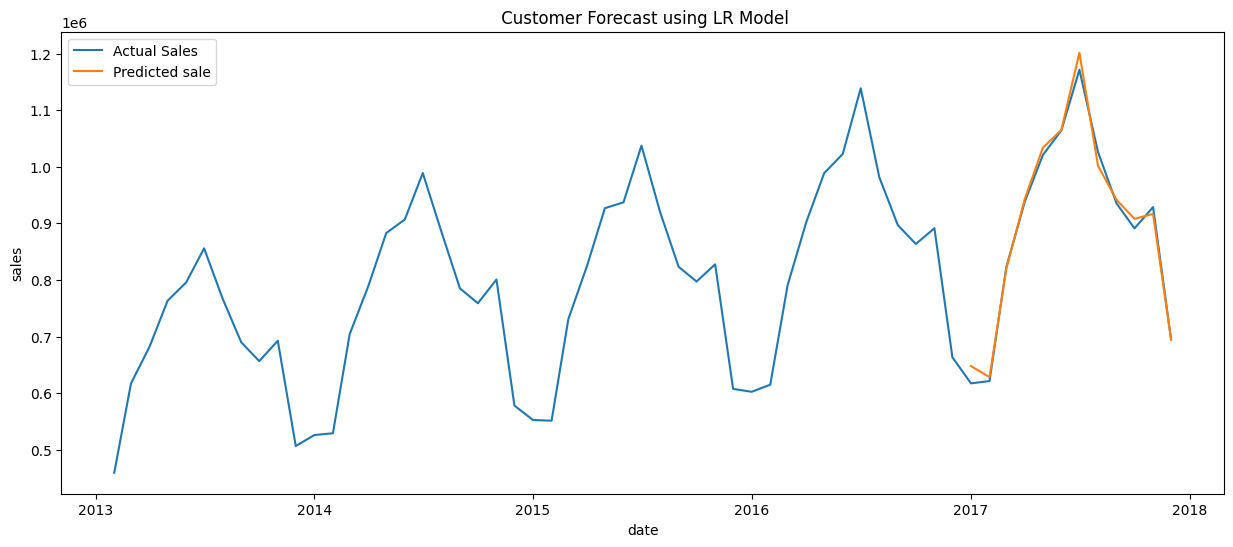

In [ ]:
plt.figure(figsize=(15,6))
#actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
#prdicted sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title(" Customer Forecast using LR Model")
plt.xlabel("date")
plt.ylabel("sales")
plt.legend(['Actual Sales', 'Predicted sale'])
plt.show()

In [ ]:
print("Predicted future sales", predict_df)

Predicted future sales          date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


**Thanks for following trough the notebook!**